# Red neuronal completamente conectada


## Arquitectura de la red


En los cursos anteriores ([curso 2](../02_RéseauFullyConnected/README.md)), construimos redes neuronales completamente conectadas para problemas de clasificación. Aquí, abordamos un problema de predicción con datos discretos.


### Inspiración del modelo


La red presentada en este cuaderno se inspira en el artículo ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

A continuación, se muestra la arquitectura de esta red:

![Bengio](./images/bengio.png)

*Figura extraída del artículo original.*


En el artículo, el modelo utiliza tres palabras como entrada para predecir la siguiente. En nuestro caso, usaremos caracteres, como en el cuaderno anterior.

**Matriz de *embedding* $C$**: Observamos que la red contiene una matriz $C$ que codifica las palabras (o caracteres) en un espacio latente. Esta práctica es común en PNL (*Procesamiento de Lenguaje Natural*), ya que acerca las palabras similares en dicho espacio. Por ejemplo, en la mayoría de las frases, se pueden intercambiar "perro" y "gato", lo que significa que estas palabras tendrán una representación cercana en el espacio latente, a diferencia de "perro" y "es".

**Resto de la red**: El resto de la red es más clásico. Toma como entrada la concatenación de los *embeddings* de las diferentes palabras (o caracteres) y predice una palabra (o carácter) como salida.


El modelo del artículo se entrena mediante la minimización de la *log-verosimilitud negativa* (como hicimos en el cuaderno anterior con el modelo bigrama).


### Nuestro enfoque


En el artículo, utilizan tres palabras para predecir la cuarta. Aplicaremos el mismo principio y predeciremos el cuarto carácter a partir de los tres caracteres anteriores.
La dimensión del espacio latente utilizada en el artículo es de 30 para un diccionario con 17,000 palabras distintas. Como tenemos 46 caracteres, elegiremos una dimensión de *embedding* de 10 de manera arbitraria.


## Implementación de la red


Comencemos por reconstruir nuestras listas `stoi` e `itos` del [cuaderno anterior](../05_NLP/02_bigramme.ipynb):


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
%matplotlib inline

In [2]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Creación del *dataset* y el *dataloader*


Construyamos nuestro *dataset*, que difiere ligeramente porque las entradas serán tres en lugar de una.


In [3]:
block_size = 3 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if (k<2): ## On affiche ce à quoi ressemble le dataset pour les deux premiers mots
      print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

... ---> M
..M ---> A
.MA ---> R
MAR ---> I
ARI ---> E
RIE ---> .
... ---> J
..J ---> E
.JE ---> A
JEA ---> N
EAN ---> .


In [4]:
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([226325, 3]) torch.int64 torch.Size([226325]) torch.int64


Ahora usaremos PyTorch para construir nuestros *datasets* de entrenamiento, validación y prueba.


In [5]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
print("Taille du dataset de training : ",len(train_dataset))
print("Taille du dataset de validation : ",len(val_dataset))
print("Taille du dataset de test : ",len(test_dataset))

Taille du dataset de training :  181060
Taille du dataset de validation :  22632
Taille du dataset de test :  22633


También crearemos nuestros *dataloaders* para la optimización por mini-lotes.


In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Capas de la red


Para comprender bien la red que estamos construyendo, no usaremos las funciones `nn.Linear()` de PyTorch para crear las capas.
Primero, definiremos el número de neuronas para cada capa.


In [7]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

Construyamos nuestra matriz $C$ de *embedding* (con parámetros entrenables).


In [8]:
C = torch.randn((46, embed_dim))
C[X].shape

torch.Size([226325, 3, 10])

Al llamar a `C[X]`, gracias a la indexación de PyTorch ([enlace](http://blog.ezyang.com/2019/05/pytorch-internals/)), obtenemos los valores de *embedding* de cada uno de los tres caracteres de nuestros 226,325 ejemplos.


Ahora podemos crear nuestras capas ocultas $W_1$ y $W_2$, así como sus sesgos $b_1$ y $b_2$.


In [9]:
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
print("Nombre de paramètres du modèle : ",sum(p.nelement() for p in parameters))

Nombre de paramètres du modèle :  15906


Para entrenar estas capas, debemos activar el parámetro `requires_grad` de PyTorch. Esto permite especificar que queremos calcular los gradientes para estos elementos.


In [10]:
for p in parameters:
  p.requires_grad = True

### ¿Cómo elegir una buena tasa de aprendizaje?


La elección de la tasa de aprendizaje es crucial durante el entrenamiento de una red neuronal y, a menudo, es difícil determinar el valor adecuado sin pruebas previas.
Un buen método para elegir la tasa de aprendizaje consiste en:
- Crear una lista de 1,000 valores entre -3 y 0.
- Tomar $10^{\text{valor}}$ para cada valor.
Esto nos da una lista de valores entre $10^{-3} = 0.001$ y $10^{0} = 1$, que son candidatos potenciales para la tasa de aprendizaje. Los valores -3 y 0 pueden variar; debe intentar encontrar valores que enmarquen la tasa de aprendizaje óptima.


In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Luego, seguiremos los valores de pérdida en función de la tasa de aprendizaje para todo el conjunto de valores de entrenamiento.


In [12]:
lri = []
lossi = []
count=0
while count<999:
  for x,y in train_loader:
    count+=1
    if count==999:
        break
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr = lrs[count]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[count])
    lossi.append(loss.log10().item())

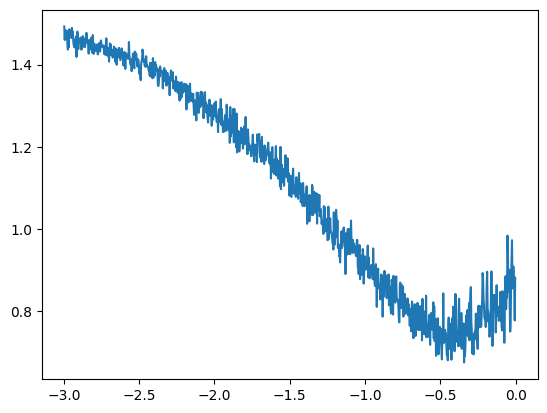

In [13]:
plt.plot(lri, lossi)

Esta curva muestra que un buen valor para la tasa de aprendizaje se encuentra entre $10^{-1}$ y $10^{-0.5}$.
Por lo tanto, elegiremos una tasa de aprendizaje de 0.2, que reduciremos durante el entrenamiento (una práctica común para una convergencia rápida y una optimización precisa al final del entrenamiento).


### La función tangente hiperbólica


En nuestra optimización, hemos utilizado la función tangente hiperbólica como función de activación.
Se define de la siguiente manera:
$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
Podemos visualizarla en Python:


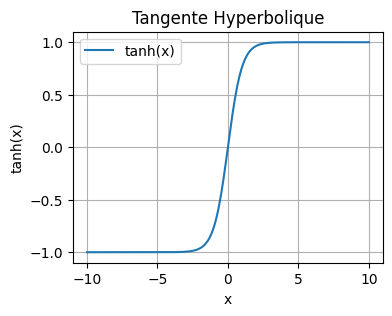

In [14]:
import numpy as np
x = np.linspace(-10, 10, 400)

y = np.tanh(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)')
plt.title('Tangente Hyperbolique')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()

En general, en las capas ocultas de nuestra red, preferimos usar la función *tanh* en lugar de la función *sigmoide* por varias razones:
- El rango de salida centrado en cero (-1 a 1) facilita el aprendizaje.
- Los gradientes son más significativos para valores entre -2 y 2 que para la función sigmoide.
- Estos dos puntos contribuyen a reducir el problema del [gradiente desvaneciente](https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54) y permiten una convergencia más rápida durante el entrenamiento.


### Optimización de la red


Pasemos ahora a la optimización de nuestra red. Definamos nuestros hiperparámetros:


In [15]:
lr=0.2
epochs=100

# Reinitialisons les paramètres pour plus de simplicité si on a besoin de relancer l'entraînement
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True


In [16]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss

  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  # Calcul du loss de validation (pour surveiller l'overfitting)
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 5.273, Validation loss: 3.519
Epoch 10 - Training loss: 2.424, Validation loss: 2.594
Epoch 20 - Training loss: 2.337, Validation loss: 2.421
Epoch 30 - Training loss: 2.289, Validation loss: 2.468
Epoch 40 - Training loss: 2.259, Validation loss: 2.424
Epoch 50 - Training loss: 2.327, Validation loss: 2.372
Epoch 60 - Training loss: 2.326, Validation loss: 2.372
Epoch 70 - Training loss: 2.326, Validation loss: 2.372
Epoch 80 - Training loss: 2.326, Validation loss: 2.372
Epoch 90 - Training loss: 2.326, Validation loss: 2.372


Trazamos las curvas de entrenamiento y validación.


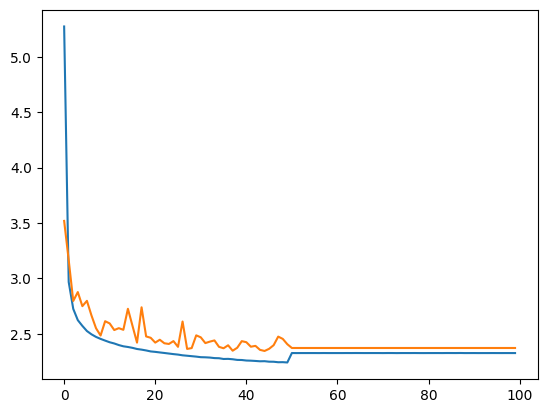

In [17]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

### Prueba del modelo


Ahora que el modelo está entrenado, verificaremos su rendimiento con los datos de prueba. Si la pérdida en los datos de prueba es similar a la del entrenamiento, entonces el modelo está bien entrenado. De lo contrario, podría haber sobreajuste (*overfitting*).


In [18]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
for p in parameters:
  p.requires_grad = False
loss_test=0
for x,y in test_loader:
      
  # forward pass
  emb = C[x]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, y)

  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.3505)


La verosimilitud en los datos de prueba es relativamente cercana a la de los datos de entrenamiento, lo que muestra que el entrenamiento se desarrolló correctamente.


Observamos que el valor de la *log-verosimilitud negativa* de nuestro modelo es inferior al del modelo bigrama del cuaderno anterior ($2.3 < 2.5$). Por lo tanto, la calidad de los nombres generados debería mejorar.


### Generación de nombres con nuestro modelo


Generemos una veintena de nombres para evaluar nosotros mismos la calidad de la generación.


In [19]:
for _ in range(20):
  out = []
  context = [0] * block_size 
  while True:
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

JAÏMANT.
SONELIUWAN.
LYPHELSÏL.
DJELINATHEYMONDALYANE.
ERNANDRAN.
ESMALLOONIS.
ASHAMLANCHOND.
ANNAE.
CHALLA.
ETTE.
ASSANE.
MARIANE.
FIHAYLAY.
SHANA.
ALPHENELIESON.
ESÏL.
EVEY.
YSLALLYSSIA.
ETHELDOF.
KELLAH.


Los nombres generados siguen siendo extraños, pero ya se parecen mucho más a nombres "posibles" en comparación con los producidos por el modelo bigrama.


**Ejercicio**: Intenta modificar el número de neuronas de las capas o los hiperparámetros para mejorar el modelo y observa la diferencia en la calidad de la generación.


## Visualización de los *embeddings*


Anteriormente en el cuaderno, explicamos la intuición detrás de la matriz de *embedding* $C$, que permite acercar las palabras (o caracteres) con significados similares. No es fácil visualizar la posición de cada carácter en la matriz $C$. Para lograrlo, reentrenaremos un modelo con una dimensión de *embedding* de 2 en lugar de 10. Esto nos permitirá visualizar la matriz $C$.

**Nota**: Para visualizar *embeddings* de dimensión superior a 2 en 2D, se puede utilizar el método [T-SNE o UMAP](https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/).


In [23]:
lr=0.2
epochs=100

C = torch.randn((46, 2)) # 2 au lieu de embed_dim
W1 = torch.randn((block_size*2, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [24]:
lossi=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 3.822, Validation loss: 3.294
Epoch 10 - Training loss: 2.490, Validation loss: 2.616
Epoch 20 - Training loss: 2.425, Validation loss: 2.532
Epoch 30 - Training loss: 2.388, Validation loss: 2.498
Epoch 40 - Training loss: 2.365, Validation loss: 2.529
Epoch 50 - Training loss: 2.386, Validation loss: 2.399
Epoch 60 - Training loss: 2.385, Validation loss: 2.399
Epoch 70 - Training loss: 2.386, Validation loss: 2.399
Epoch 80 - Training loss: 2.385, Validation loss: 2.399
Epoch 90 - Training loss: 2.385, Validation loss: 2.399


Como pueden ver, la pérdida es más alta porque una dimensión de *embedding* de 2 es insuficiente para representar correctamente cada carácter.
Sin embargo, ahora podemos visualizar la posición de los caracteres en el espacio latente.


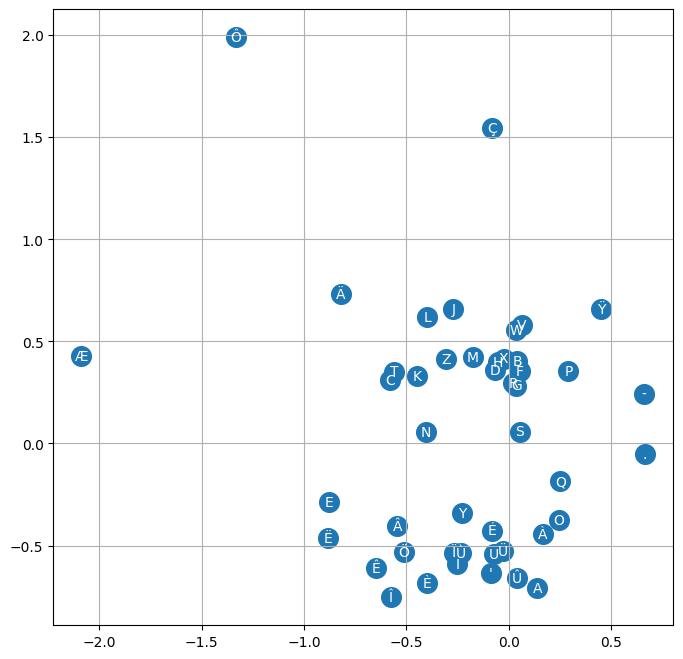

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Observamos una tendencia con un agrupamiento de vocales y consonantes (a menudo intercambiables en un nombre). Los caracteres raros tienen *embeddings* distintos ('ç', 'ö', 'ë'). También notamos la proximidad entre '.' y '-', lo cual es lógico para un nombre compuesto en francés.
Esto muestra que la matriz $C$ ha aprendido una especie de *mapeo* de los caracteres según su proximidad semántica.
